In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


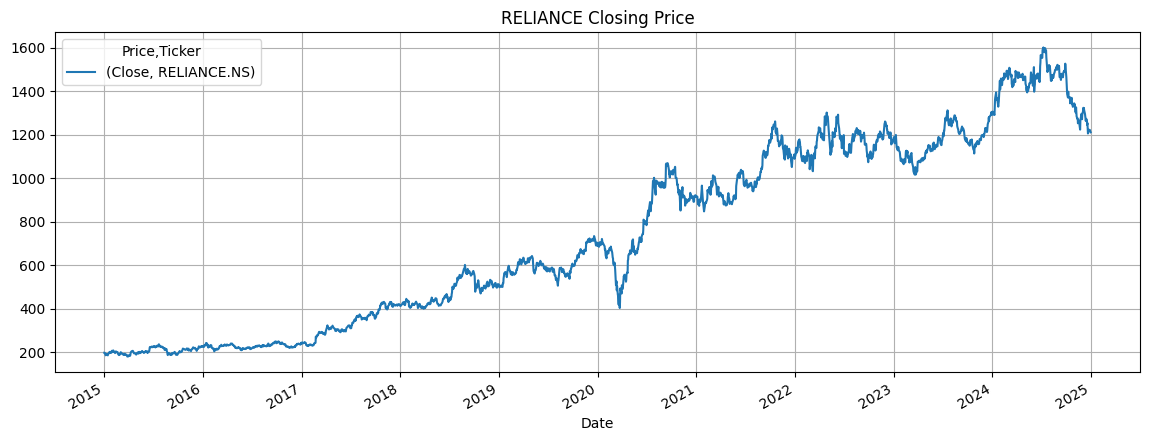

In [2]:
df = yf.download("RELIANCE.NS", start="2015-01-01", end="2024-12-31")
df = df[['Close']].dropna()
df.plot(figsize=(14, 5), title="RELIANCE Closing Price")
plt.grid(); plt.show()


In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 60)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [4]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [5]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0181 - val_loss: 5.6669e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.4881e-04 - val_loss: 5.3128e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.0174e-04 - val_loss: 4.9941e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.0658e-04 - val_loss: 4.7490e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.9833e-04 - val_loss: 4.4992e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.0310e-04 - val_loss: 4.4329e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.8618e-04 - val_loss: 4.2218e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.6026e-04 - val_loss: 6.8088e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.7808e-04 - val_loss: 3.9010e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.0043e-04 - val_loss: 3.7474e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.5235e-04 - val_loss: 3

In [6]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
MSE: 513.01
MAE: 17.32


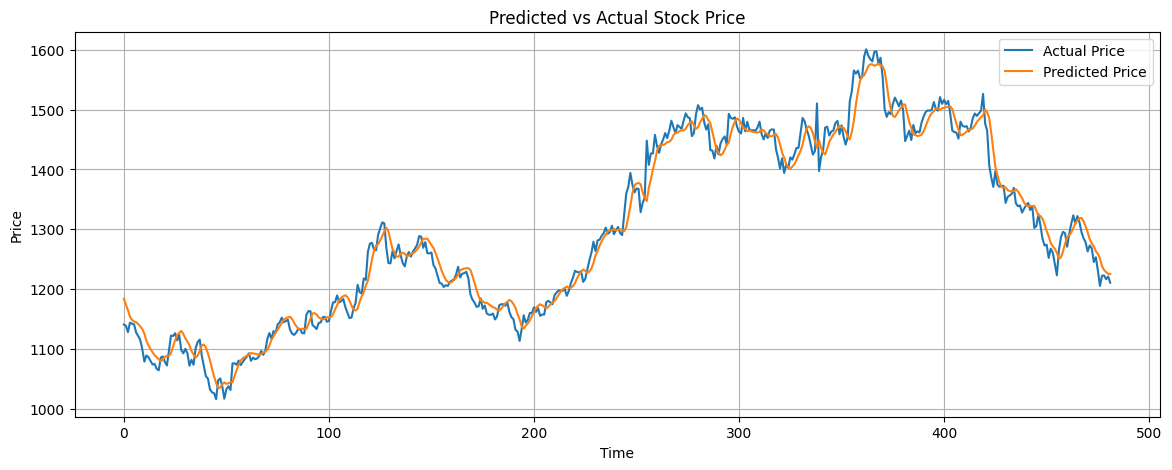

In [7]:
plt.figure(figsize=(14,5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Predicted vs Actual Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [8]:
last_60 = scaled_data[-60:].reshape(1, 60, 1)
predicted_next_scaled = model.predict(last_60)
predicted_next = scaler.inverse_transform(predicted_next_scaled)

print(f"Predicted next-day closing price: ₹{predicted_next[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted next-day closing price: ₹1223.25
